# Setup

In [1]:
# Import modules

import os, glob
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'
#num_workers = multiprocessing.cpu_count()
num_workers = 0
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Tue May 31 22:04:56 2022
TorchIO version: 0.18.76


In [2]:
compute_histograms = False
train_whole_images = False 
train_patches = False

EPOCHS = 10
NUM_CLASSES = 3

#histogram_landmarks_path = 'landmarks.npy'
DATA_DIR = '/media/trojan/trojan/3D-CT-Artery-Segmentation/data_splitted'

# Data

In [3]:
images_dir = os.path.join(DATA_DIR, 'train/volumes')
labels_dir = os.path.join(DATA_DIR, 'train/masks')
image_paths = sorted(glob.glob(images_dir + '/' + '*.nii.gz'))
label_paths = sorted(glob.glob(labels_dir + '/' + '*.nii.gz'))
assert len(image_paths) == len(label_paths)

training_subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    training_subjects.append(subject)
training_dataset = tio.SubjectsDataset(training_subjects)
print('Dataset size:', len(training_dataset), 'training subjects')

Dataset size: 612 training subjects


In [4]:
validation_images_dir = os.path.join(DATA_DIR, 'val/volumes')
validation_labels_dir = os.path.join(DATA_DIR, 'val/masks')
validation_image_paths = sorted(glob.glob(validation_images_dir + '/' + '*.nii.gz'))
validation_label_paths = sorted(glob.glob(validation_labels_dir + '/' + '*.nii.gz'))
assert len(validation_image_paths) == len(validation_label_paths)

validation_subjects = []
for (image_path, label_path) in zip(validation_image_paths, validation_label_paths):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    validation_subjects.append(subject)
validation_dataset = tio.SubjectsDataset(validation_subjects)
print('Dataset size:', len(validation_dataset), 'validation subjects')

Dataset size: 204 validation subjects


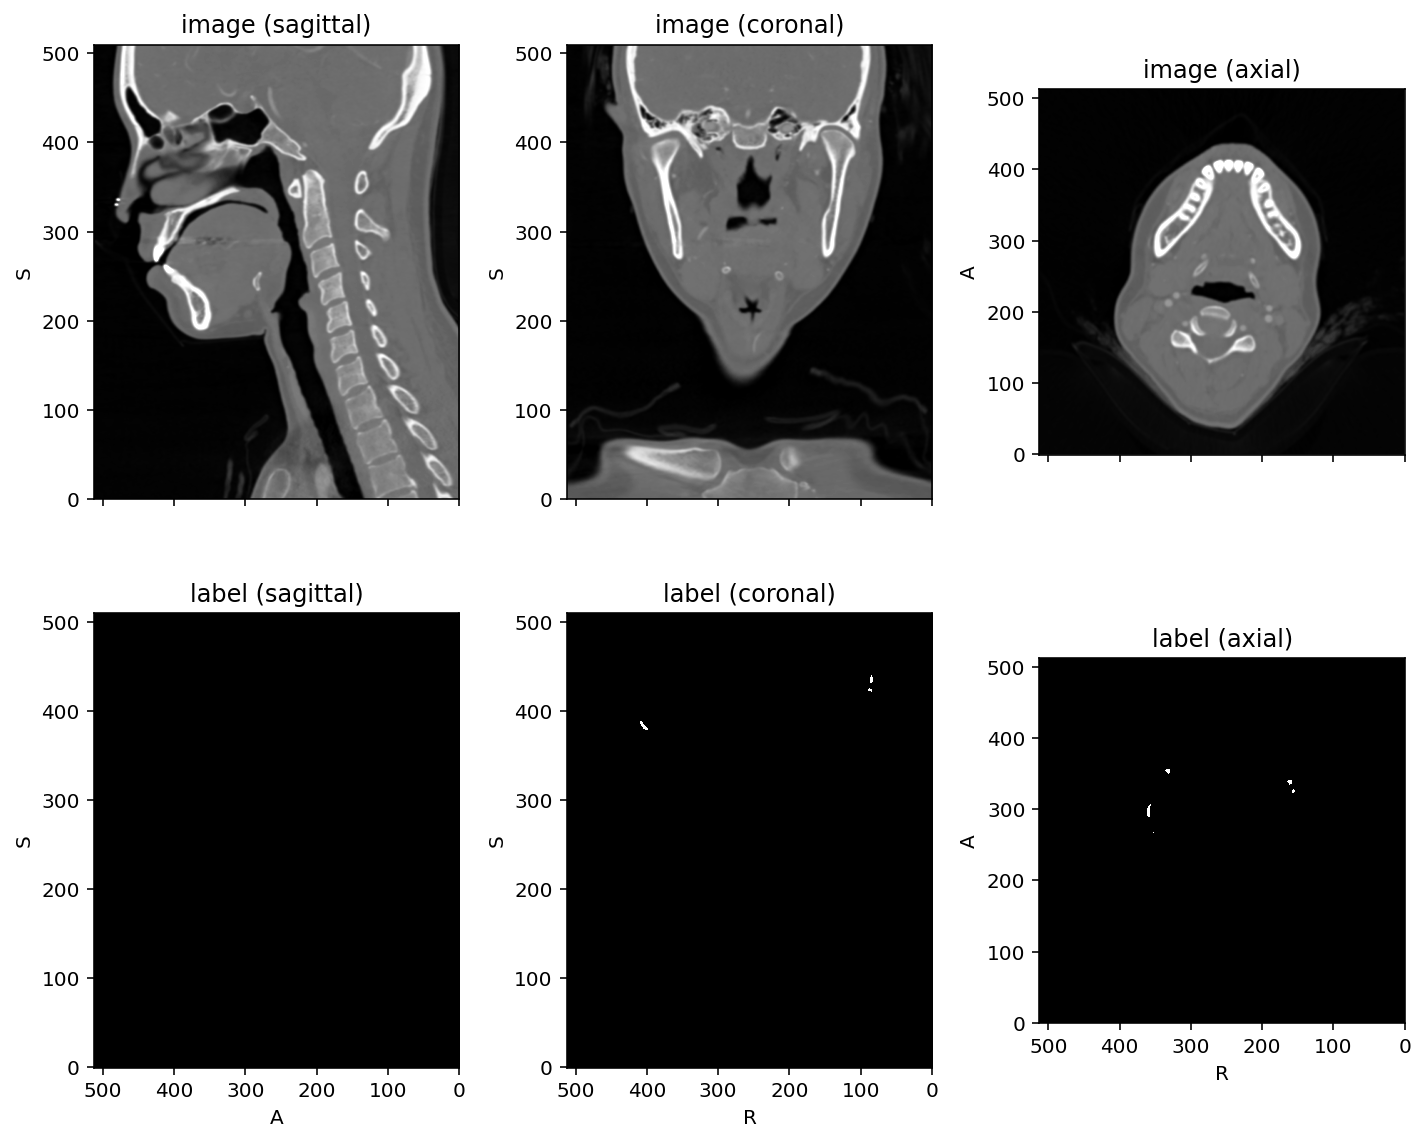

In [5]:
one_subject = training_dataset[0]
one_subject.plot(figsize=(10,10))

In [6]:
print(one_subject)
print(one_subject.image)
print(one_subject.label)

Subject(Keys: ('image', 'label'); images: 2)
ScalarImage(shape: (1, 513, 513, 510); spacing: (0.40, 0.40, 0.50); orientation: LPS+; dtype: torch.ShortTensor; memory: 256.0 MiB)
LabelMap(shape: (1, 513, 513, 510); spacing: (0.40, 0.40, 0.50); orientation: LPS+; dtype: torch.ShortTensor; memory: 256.0 MiB)


# Preprocessing

## Normalization
We will use the `ZNormalization` transform to normalize our images intensity. Z-standardization or normalization means that our output data will have zero mean and unit variance. 

In [7]:
# def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
#     values = tensor.numpy().ravel()
#     kernel = stats.gaussian_kde(values)
#     positions = np.linspace(values.min(), values.max(), num=num_positions)
#     histogram = kernel(positions)
#     kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
#     if label is not None:
#         kwargs['label'] = label
#     axis.plot(positions, histogram, **kwargs)

In [8]:
##### Takes long, try later #####

In [9]:
# if compute_histograms:
#     fig, ax = plt.subplots(dpi=100)
#     for path in tqdm(paths):
#         tensor = tio.ScalarImage(path).data
#         if 'HH' in path.name: color = 'red'
#         elif 'Guys' in path.name: color = 'green'
#         elif 'IOP' in path.name: color = 'blue'
#         plot_histogram(ax, tensor, color=color)
#     ax.set_xlim(-100, 2000)
#     ax.set_ylim(0, 0.004);
#     ax.set_title('Original histograms of all samples')
#     ax.set_xlabel('Intensity')
#     ax.grid()
#     graph = None
# else:
#     graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
# graph

In [10]:
# landmarks = tio.HistogramStandardization.training(
#     image_paths,
#     output_path=histogram_landmarks_path,
# )
# np.set_printoptions(suppress=True, precision=3)
# print('\ntraininged landmarks:', landmarks)

In [11]:
# landmarks_dict = {'image': landmarks}
# histogram_transform = tio.HistogramStandardization(landmarks_dict)

# if compute_histograms:
#     fig, ax = plt.subplots(dpi=100)
#     for i ,sample in enumerate(tqdm(dataset)):
#         standard = histogram_transform(sample)
#         tensor = standard.image.data
#         path = str(sample.image.path)
#         if 'HH' in path: color = 'red'
#         elif 'Guys' in path: color = 'green'
#         elif 'IOP' in path: color = 'blue'
#         plot_histogram(ax, tensor, color=color)
#     ax.set_xlim(0, 150)
#     ax.set_ylim(0, 0.02)
#     ax.set_title('Intensity validationues of all samples after histogram standardization')
#     ax.set_xlabel('Intensity')
#     ax.grid()
#     graph = None
# else:
#     graph = display.Image(url='https://www.dropbox.com/s/dqqaf78c86mrsgn/hist_standard.png?dl=1')
# graph

In [12]:
###############################################

In [13]:
# # Apply normalization and visualize
# znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

# # transform = tio.Compose([histogram_transform, znorm_transform])
# # znormed = transform(sample)

# sample = training_dataset[0]
# znormed = znorm_transform(sample)

# fig, ax = plt.subplots(dpi=100)
# plot_histogram(ax, znormed.image.data, label='Z-normed', alpha=1)
# ax.set_title('Intensity validationues of one sample after z-normalization')
# ax.set_xlabel('Intensity')
# ax.grid()

In [14]:
# # Intensities before normalization
# sample = training_dataset[0]

# fig, ax = plt.subplots(dpi=100)
# plot_histogram(ax, sample.image.data, label='Z-normed', alpha=1)
# ax.set_title('Intensity validationues of one sample after z-normalization')
# ax.set_xlabel('Intensity')
# ax.grid()

In [15]:
# sample = training_dataset[0]
# print(sample.image.data.min(), sample.image.data.max())

In [16]:
# print(sample.label.data.min(), sample.label.data.max())
# print(np.unique(sample.label.data))

In [17]:
# znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)
# znormed = znorm_transform(sample)
# print(znormed.image.data.min(), znormed.image.data.max())
# print(np.unique(znormed.label.data))

In [18]:
# print(znormed.image.data.dtype)
# print(znormed.label.data.dtype)

In [19]:
########## One hot testing ##################

In [20]:
# sample = training_dataset[0]

In [21]:
# transform = tio.OneHot()
# #transform = tio.ToCanonical()
# #transform = tio.CropOrPad((512, 512, 512))
# #transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)
# transformed = transform(sample)

In [22]:
# print(transformed)
# print(transformed.image)
# print(transformed.label)

In [23]:
##########################################

# Training the network

## Prepare data

In [24]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(num_classes=NUM_CLASSES),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(num_classes=NUM_CLASSES),
])

num_training_subjects = len(training_dataset)
num_validation_subjects = len(validation_dataset)

torch.utils.data.DataLoader(training_dataset)
                            
training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('training set:', len(training_set), 'subjects')
print('validation set:', len(validation_set), 'subjects')

training set: 612 subjects
validation set: 204 subjects


## Deep learning stuff

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [26]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

In [27]:
# Define loss function

# def ce_loss(output, target, criterion=torch.nn.CrossEntropyLoss()):
#     loss = criterion(output, target.squeeze().long())
#     return loss

# def dice_loss(pred, target):
#         smooth = 1
#         dice = 0.
#         for i in range(pred.size(1)):
#             dice += 2 * (pred[:,i] * target[:,i]).sum(dim=1).sum(dim=1).sum(dim=1) / (pred[:,i].pow(2).sum(dim=1).sum(dim=1).sum(dim=1) +
#                                                 target[:,i].pow(2).sum(dim=1).sum(dim=1).sum(dim=1) + smooth)
#         dice = dice / pred.size(1)
#         return torch.clamp((1 - dice).mean(), 0, 1)
    
# def dice_loss(output, target):
#     smooth = 1.
#     loss = 0.
#     for c in range(NUM_CLASSES):
#         oflat = output[:, c ].contiguous().view(-1)
#         tflat = target[:, c].contiguous().view(-1)
#         intersection = (oflat * tflat).sum()
           
#         #w = class_weights[c]
#         loss += (1 - ((2. * intersection + smooth) /
#                              (oflat.sum() + tflat.sum() + smooth)))
#     return loss

# def ce_loss(output, target, criterion = torch.nn.CrossEntropyLoss()):
#     output = output.permute(0,2,3,4,1).contiguous()
#     output = output.view(output.numel() // 4, 4)
#     target = target.view(-1)
#     loss = criterion(output, target)
#     return loss
    

# It is only for binary class, checl multi class
# Ref: https://github.com/pytorch/pytorch/issues/1249
# def get_dice_loss(output, target):
#     smooth = 1.

#     outflat = output.view(-1)
#     tflat = target.view(-1)
#     intersection = (outflat * tflat).sum()
    
#     return 1 - ((2. * intersection + smooth) /
#               (outflat.sum() + tflat.sum() + smooth))

def dice_loss(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return 1 - dice_score
    

# def get_dice_score(y_true, y_pred):
#     smoothing_factor = 1
#     flat_y_true = torch.flatten(y_true)
#     flat_y_pred = torch.flatten(y_pred)
#     return (2. * torch.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (torch.sum(flat_y_true) + torch.sum(flat_y_pred) + smoothing_factor)

# def get_dice_loss(y_true, y_pred):
#     return 1 - get_dice_score(y_true, y_pred)

In [28]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    
def prepare_batch(batch, device):
    inputs = batch['image'][tio.DATA].to(device)
    targets = batch['label'][tio.DATA].to(device)
#     inputs = batch['image'][tio.DATA].type(torch.float32).to(device)
#     targets = batch['label'][tio.DATA].type(torch.float32).to(device)
    return inputs, targets

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=NUM_CLASSES,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
#             print(probabilities.shape)
#             print(targets.shape)
            batch_losses = dice_loss(probabilities, targets)
            #batch_losses = ce_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f"{action.value} mean loss: {epoch_losses.mean():0.3f}")
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'./model/weights/{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

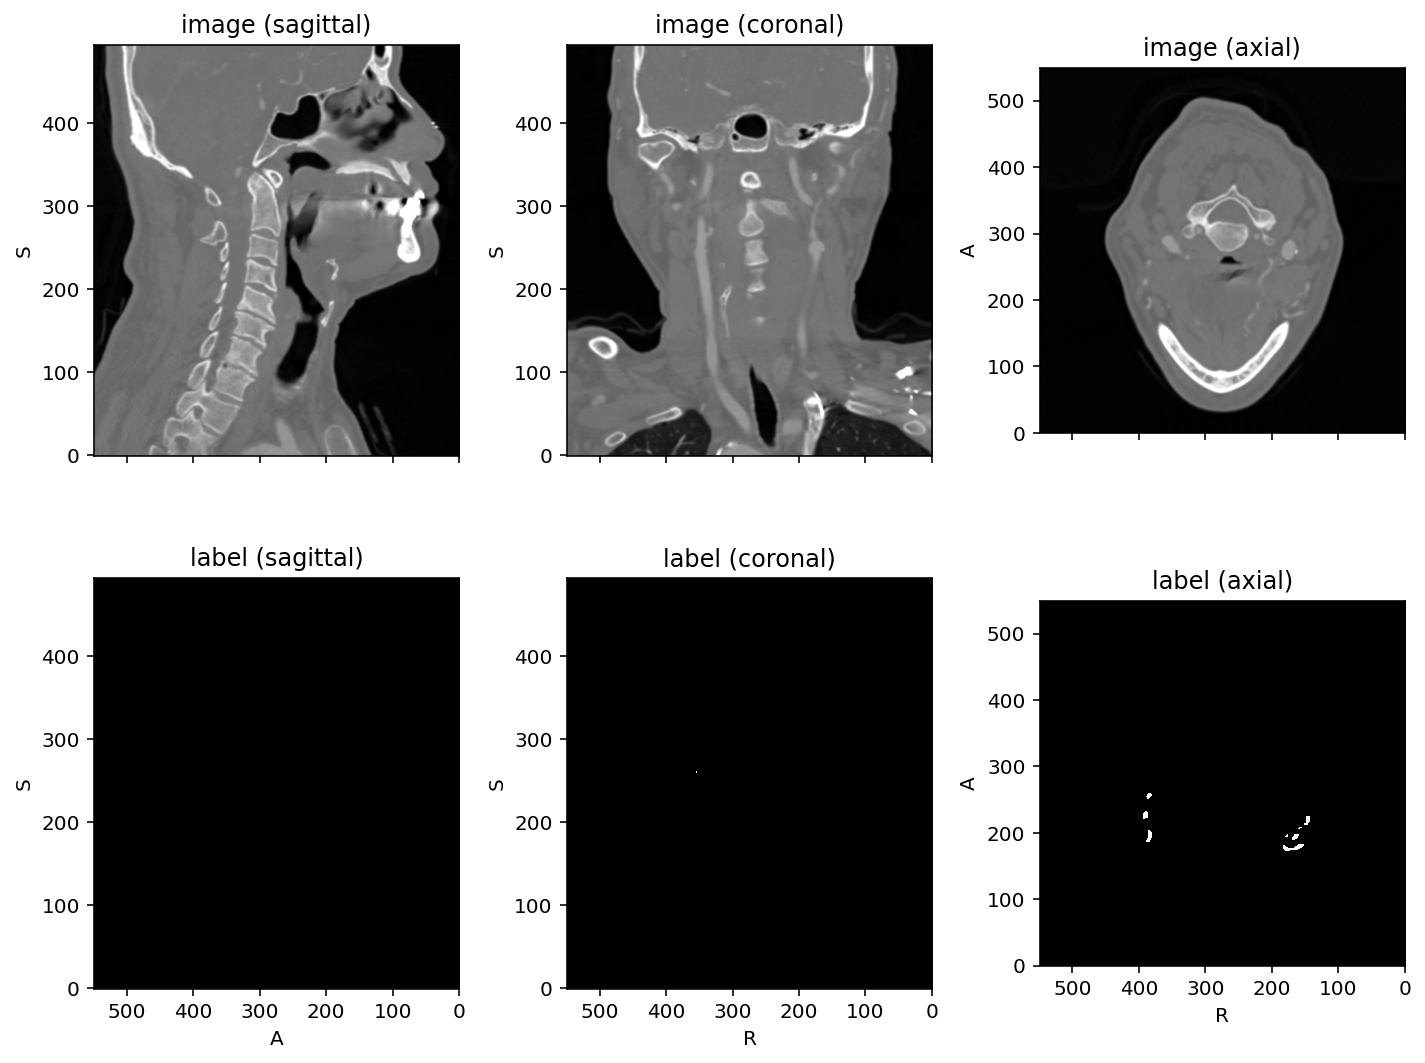

In [29]:
training_instance = training_set[85]  # transform is applied inside SubjectsDataset
training_instance.plot(figsize=(10,10))

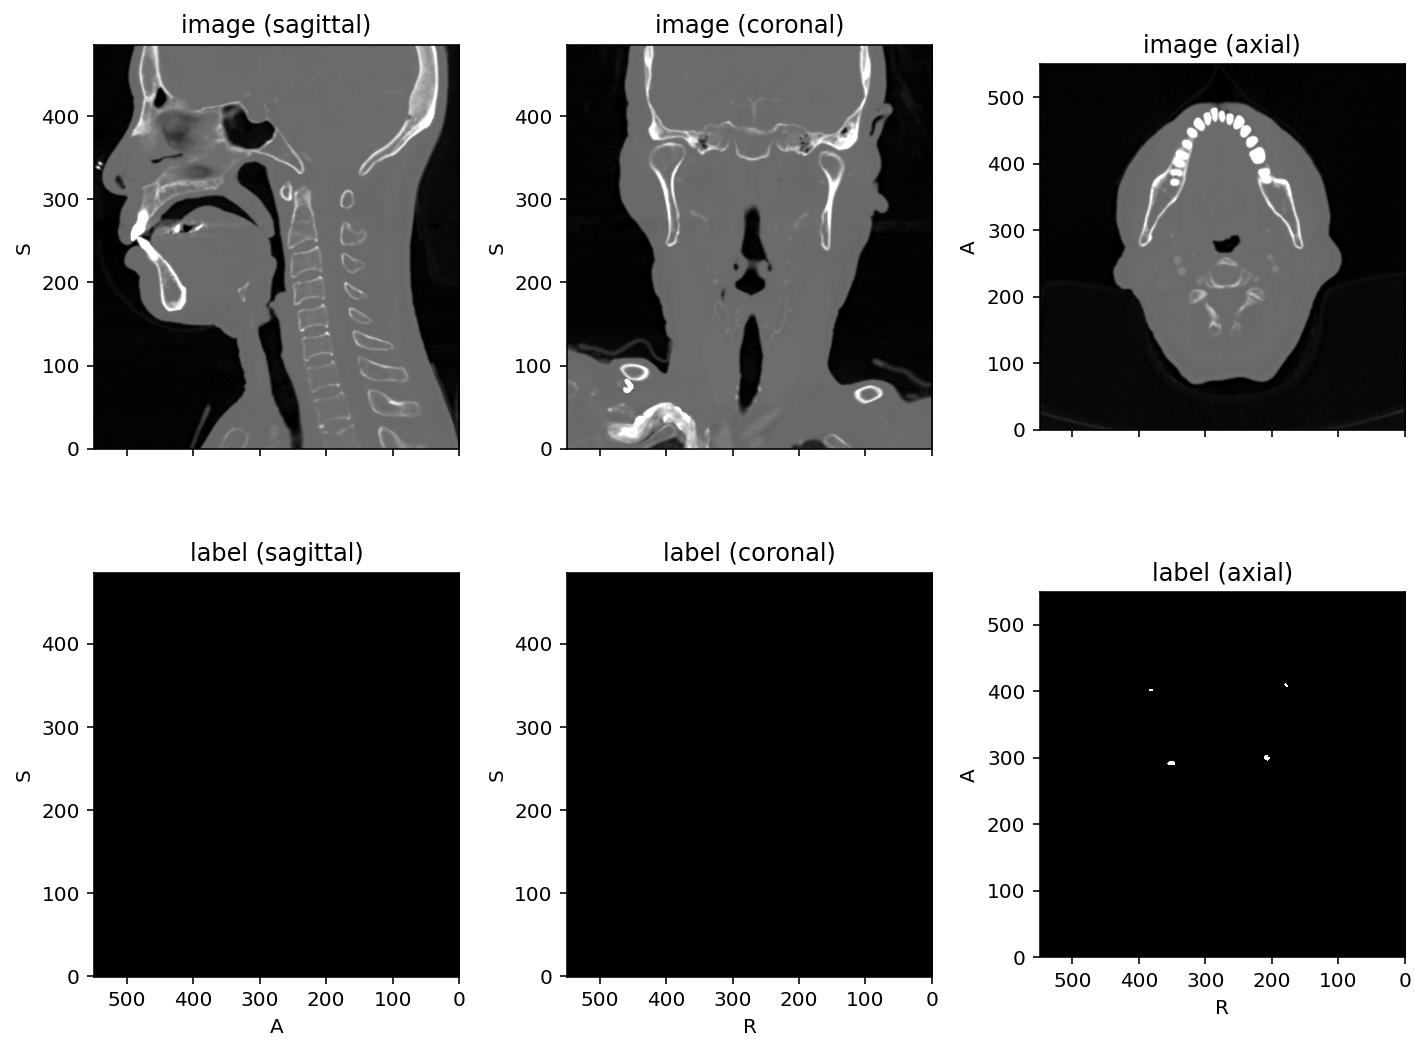

In [30]:
validation_instance = validation_set[85]
validation_instance.plot(figsize=(10,10))

In [31]:
# Check shape
print(training_instance.items())

dict_items([('image', ScalarImage(shape: (1, 550, 550, 494); spacing: (0.40, 0.40, 0.50); orientation: RAS+; dtype: torch.FloatTensor; memory: 570.0 MiB)), ('label', LabelMap(shape: (3, 550, 550, 494); spacing: (0.40, 0.40, 0.50); orientation: RAS+; dtype: torch.ShortTensor; memory: 855.1 MiB))])


## Whole images

Did not work. CUDA out of memory.

In [32]:
# train_whole_images = True

In [33]:
# training_batch_size = 1
# validation_batch_size = training_batch_size

# training_loader = torch.utils.data.DataLoader(
#     training_set,
#     batch_size=training_batch_size,
#     shuffle=True,
#     num_workers=num_workers,
# )

# validation_loader = torch.utils.data.DataLoader(
#     validation_set,
#     batch_size=validation_batch_size,
#     num_workers=num_workers,
# )

In [34]:
# one_batch = next(iter(training_loader))

In [35]:
# k = 50

# batch_image = one_batch['image'][tio.DATA][..., k]
# image_path = 'batch_whole_images.png'

# torchvision.utils.save_image(
#     batch_image,
#     image_path,
#     nrow=training_batch_size,
#     normalize=True,
#     scale_each=True,
#     padding=0
# )
# display.Image(image_path)

In [36]:
# batch_label = one_batch['label'][tio.DATA][..., k].float()
# label_path = 'batch_whole_labels.png'

# torchvision.utils.save_image(
#     batch_label,
#     label_path,
#     nrow=training_batch_size,
#     normalize=True,
#     scale_each=True,
#     padding=0
# )
# display.Image(label_path)

In [37]:
# model, optimizer = get_model_and_optimizer(device)
# weights_path = './model/weights/patches_state_dict.pth'

# if train_whole_images:
#     weights_stem = 'whole_images'
#     train_losses, val_losses = train(
#         num_epochs,
#         training_loader,
#         validation_loader,
#         model,
#         optimizer,
#         weights_stem,
#     )
#     checkpoint = {
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'weights': model.state_dict(),
#     }
#     torch.save(checkpoint, weights_path)
    
# else:
#     checkpoint=torch.load(weights_path)
#     model.load_state_dict(checkpoint['weights'])
#     train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']
    
# def plot_times(axis, losses, label):
#     from datetime import datetime
#     times, losses = losses.transpose(1, 0, 2)
#     times = [datetime.fromtimestamp(x) for x in times.flatten()]
#     axis.plot(times, losses.flatten(), label=label)
    
# fig, ax = plt.subplots()
# plot_times(ax, train_losses, 'Training')
# plot_times(ax, val_losses, 'Validation')
# ax.grid()
# ax.set_xlabel('Time')
# ax.set_ylabel('Dice loss')
# ax.set_title('Training with whole images')
# ax.legend() 
# fig.autofmt_xdate()

## Patch-based

Reference: https://torchio.readthedocs.io/_modules/torchio/data/queue.html

In [38]:
train_patches = True

In [39]:
training_batch_size = 4
validation_batch_size = training_batch_size

patch_size = 128,128,64
samples_per_volume = 8  # 32: 18
max_queue_length = 320
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [40]:
# one_batch = next(iter(training_loader_patches))
# k = int(patch_size // 4)
# inputs, targets = prepare_batch(one_batch, device)
# print(inputs.shape)
# print(targets.shape)

In [41]:
# one_batch = next(iter(validation_loader_patches))
# k = int(patch_size // 4)
# inputs, targets = prepare_batch(one_batch, device)
# print(inputs.shape)
# print(targets.shape)

In [42]:

# batch_image = one_batch['image'][tio.DATA][..., k]
# #slices = torch.cat((batch_image, batch_label))
# image_path = 'batch_image_patches.png'

# torchvision.utils.save_image(
#     batch_image,
#     image_path,
#     nrow=training_batch_size,
#     normalize=True,
#     scale_each=True,
# )
# display.Image(image_path)

In [43]:
# batch_label = one_batch['label'][tio.DATA][..., k]
# label_path = 'batch_label_patches.png'

# torchvision.utils.save_image(
#     batch_label,
#     label_path,
#     nrow=training_batch_size,
#     normalize=True,
#     scale_each=True,
# )
# display.Image(label_path)

## Train

In [44]:
# model, optimizer = get_model_and_optimizer(device)
# weights_path = './model/weights/patches_state_dict.pth'

# if train_patches:
#     weights_stem = 'patches'
#     train_losses, val_losses = train(
#         EPOCHS,
#         training_loader_patches,
#         validation_loader_patches,
#         model,
#         optimizer,
#         weights_stem,
#     )
#     checkpoint = {
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'weights': model.state_dict(),
#     }
#     torch.save(checkpoint, weights_path)
    
# else:
#     checkpoint = torch.load(weights_path)
#     model.load_state_dict(checkpoint['weights'])
#     train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

Number of patients: 204\
Patch size: 128\
Number of patches: 64\
Batch size: 4\
(204*64) / 4 = 3264

In [45]:
# def plot_times(axis, losses, label):
#     from datetime import datetime
#     times, losses = losses.transpose(1, 0, 2)
#     times = [datetime.fromtimestamp(x) for x in times.flatten()]
#     axis.plot(times, losses.flatten(), label=label)

    
# fig, ax = plt.subplots()
# plot_times(ax, train_losses, 'Training')
# plot_times(ax, val_losses, 'Validation')
# ax.grid()
# ax.set_xlabel('Time')
# ax.set_ylabel('Dice loss')
# ax.set_title('Training with patches (subvolumes)')
# ax.legend() 
# fig.autofmt_xdate()

In [46]:
model, optimizer = get_model_and_optimizer(device)
weights_path = './model/weights/patches_state_dict.pth'

if train_patches:
    weights_stem = 'patches'
    train_losses, val_losses = train(
        EPOCHS,
        training_loader_patches,
        validation_loader_patches,
        model,
        optimizer,
        weights_stem,
    )
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
    
else:
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

  0%|          | 0/408 [00:00<?, ?it/s]

/home/trojan/.local/lib/python3.9/site-packages/unet/decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2


Validation mean loss: 0.825
Starting epoch 1


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.689


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.668
Starting epoch 2


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 3


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 4


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 5


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 6


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 7


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 8


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 9


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667
Starting epoch 10


  0%|          | 0/1224 [00:00<?, ?it/s]

Training mean loss: 0.667


  0%|          | 0/408 [00:00<?, ?it/s]

Validation mean loss: 0.667


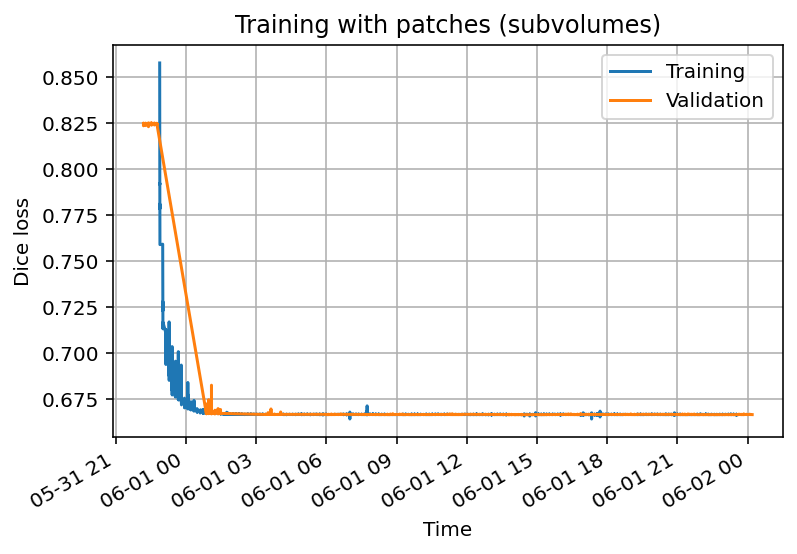

In [47]:
def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)

    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with patches (subvolumes)')
ax.legend() 
fig.autofmt_xdate()